## Practica Nº3. Formación en Modelos Predictivos (I) ##
(Segundo planteamiento)

**Introducción**

Las enfermedades cardiovasculares (ECV) son la principal causa de muerte en todo el mundo y
se cobran aproximadamente 17,9 millones de vidas cada año, lo que representa el 31 % de
todas las muertes en todo el mundo.
La insuficiencia cardíaca es un evento común causado por ECV y este conjunto de datos
contiene 12 características que pueden usarse para predecir la mortalidad por insuficiencia
cardíaca.

La mayoría de las enfermedades cardiovasculares se pueden prevenir abordando los factores
de riesgo conductuales, como el tabaquismo, la dieta poco saludable y la obesidad, la
inactividad física y el consumo nocivo de alcohol, mediante estrategias que abarquen a toda la
población.

Las personas con enfermedades cardiovasculares o que tienen un alto riesgo cardiovascular
(por la presencia de uno o más factores de riesgo como hipertensión, diabetes, hiperlipidemia
o enfermedad ya establecida) necesitan una detección y manejo temprano en el que un
modelo de aprendizaje automático puede ser de gran ayuda.

Se nos ha encargado crear un modelo predictivo para conocer si una persona podrá sufrir una
ECV, y estimar el plazo de tiempo en que podría ocurrirle.
Hemos recibido el dataset que verás a continuación, en formato CSV, para realizar el ejercicio.
Acceso al dataset: https://apioverstand.es/training/dataset_heart.zip

**Descripcion de las columnas**

* age: Edad del paciente (40-95)
* anaemia: Paciente con anemia. 1:SI, 0:NO
* creatinine_phosphokinase: Nivel de la enzima CPK en la sangre (mcg/L) [23, ..., 7861]
* diabetes: Paciente diabetico. 1:SI, 0:NO
* ejection_fraction: Porcentaje de perdida de sangre (Porcentaje) [14, ..., 80]
* high_blood_pressure: Presion arterial alta. 1:SI, 0:NO
* platelets: Plaquetas en sangre kiloplaquetas/ml [25,01, ..., 850,00]
* serum_creatinine: Nivel de creatinina en sangre mg/dL [0,50, ..., 9,40]
* serum_sodium: Nivel de sodio en sangre mEq/L [114, ..., 148]
* sex: Hombre: 1. Mujer: 0. 
* smoking: Fumador: 1. No fumador: 0
* time: Periodo de seguimiento Días [4,...,285] **[2ª variable objetivo]**
* DEATH_EVENT: Fallecido: 1. Sano: 0 **[1ª variable objetivo]**

**PASO 1. ANALISIS DE LOS DATOS**

**1.1. Importar librerias**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

**1.2. Importar dataset**

In [2]:
path = 'heart_failure_clinical_records_dataset.csv'
df = pd.read_csv(path)
df.sample(5) # Mostramos algunos registros aleatorios

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
164,45,0,2442,1,30,0,334000.0,1.1,139,1,0,129,1
198,50,1,582,1,20,1,279000.0,1.0,134,0,0,186,0
93,60,1,154,0,25,0,210000.0,1.7,135,1,0,82,1
197,65,0,167,0,30,0,259000.0,0.8,138,0,0,186,0
75,60,1,47,0,20,0,204000.0,0.7,139,1,1,73,1


**1.3. Informacion del dataset**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    int64  
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(2), int64(11)
memory usage: 30.5 KB


**PASO 2. PREPARACION DE LOS DATOS**

**2.1. Valores unicos en cada columna**

In [4]:
for col in df.columns:
    print(f'{col}, {len(df[col].unique())}')

age, 46
anaemia, 2
creatinine_phosphokinase, 208
diabetes, 2
ejection_fraction, 17
high_blood_pressure, 2
platelets, 176
serum_creatinine, 40
serum_sodium, 27
sex, 2
smoking, 2
time, 148
DEATH_EVENT, 2


**2.2. SEPARACION DE COLUMNAS SEGUN EL TIPO DE DATOS (NUMERICOS O CATEGORICOS)**

In [5]:
cat_cols = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking','DEATH_EVENT']
num_cols = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

**2.3. Valores minimos, medios y maximos de las columnas numericas**

In [6]:
df[num_cols].describe().T[['min', '50%','max']].rename(columns={'50%':'avg'})

,min,avg,max
age,40.0,60.0,95.0
creatinine_phosphokinase,23.0,250.0,7861.0
ejection_fraction,14.0,38.0,80.0
platelets,25100.0,262000.0,850000.0
serum_creatinine,0.5,1.1,9.4
serum_sodium,113.0,137.0,148.0
time,4.0,115.0,285.0


**PASO 3. ANALISIS EXPLORATORIO DE DATOS**

**3.1. Distribucion de las caracteristicas mas influyentes sobre la variable objetivo (DEATH_EVENT)**

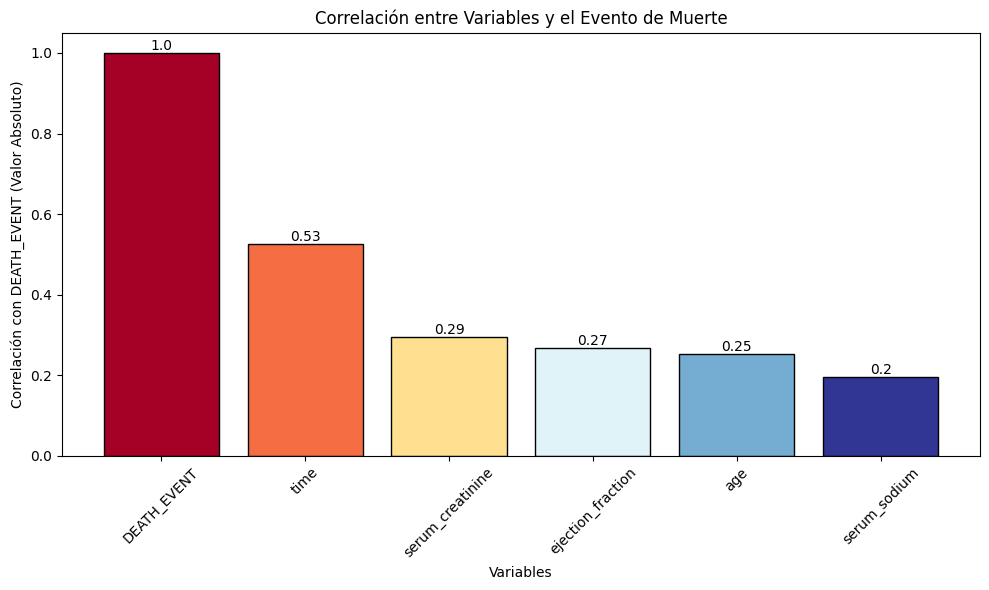

In [7]:
# Calcula la correlación entre las variables y el evento de muerte
corr = df.corr()['DEATH_EVENT'].abs().sort_values(ascending=False)

# Filtra las variables que tienen una correlación mayor a 0.1 (puedes ajustar este umbral)
relevant_variables = corr[corr > 0.1]

# Ordena las variables por correlación en orden descendente
relevant_variables = relevant_variables.sort_values(ascending=False)

# Define un mapa de color que vaya de azul (0) a rojo (1) basado en los valores de correlación
color_map = plt.cm.RdYlBu(np.linspace(0, 1, len(relevant_variables)))

# Crea una gráfica de barras con colores basados en el mapa de color
plt.figure(figsize=(10, 6))
bars = plt.bar(relevant_variables.index, relevant_variables.values, color=color_map, edgecolor='black')
plt.xlabel('Variables')
plt.ylabel('Correlación con DEATH_EVENT (Valor Absoluto)')
plt.title('Correlación entre Variables y el Evento de Muerte')

# Agrega el índice de cada variable en medio de sus respectivas barras en color negro
for bar, color in zip(bars, color_map):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', color='black')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [8]:
# Igual al anterior en formato texto
corr = df.corr()
corr[abs(corr['DEATH_EVENT']) > 0.1]['DEATH_EVENT'].sort_values()

time                -0.526964
ejection_fraction   -0.268603
serum_sodium        -0.195204
age                  0.253581
serum_creatinine     0.294278
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

**3.2. ELIMINAR LAS COLUMNAS MENOS RELEVANTES**

In [9]:
# Eliminamos columnas que menos relacion tienen con la variable objetivo.
# Recorremos el bucle para eliminar de ambas listas, tanto categoricas como numericas
rem_cols = ['platelets', 'smoking', 'sex', 'diabetes']

for e in rem_cols:
    if df[e].nunique()>5:
        num_cols.remove(e)
    else:
        cat_cols.remove(e)
        
df = df.drop(rem_cols, axis=1)

print("Categorical: ",cat_cols)
print("Numurical: ",num_cols)

Categorical:  ['anaemia', 'high_blood_pressure', 'DEATH_EVENT']
Numurical:  ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']


**3.3. COPIA DEL DATAFRAME ORIGINAL**

In [10]:
# Despues de eliminar las columnas menos relevantes y antes de normalizar los datos
# hacemos copia del df porque la vamos a necesitar mas adelante para estimar la variable tiempo
df_reducido = df
df_reducido.sample(5)

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium,time,DEATH_EVENT
101,75,0,582,45,1,1.18,137,87,0
56,70,1,75,35,0,2.70,138,54,0
75,60,1,47,20,0,0.70,139,73,1
254,53,1,446,60,1,1.00,139,215,0
20,65,1,52,25,1,1.30,137,16,0


**PASO 4. PRE-PROCESAMIENTO DE LOS DATOS**

**4.1. Escalado de caracteristicas**

In [11]:
# Transformamos las escalas de caracteristicas de las columnas numericas
# en el rango entre -1 y +1
scaler = StandardScaler() # scaling in range [-1, 1]
standard_df = scaler.fit_transform(df[num_cols])
standard_df = pd.DataFrame(standard_df, columns=num_cols)
standard_df.head()

,age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,serum_sodium,time
0,1.193302,0.000166,-1.530560,0.490057,-1.504036,-1.629502
1,-0.490896,7.514640,-0.007077,-0.284552,-0.141976,-1.603691
2,0.351203,-0.449939,-1.530560,-0.090900,-1.731046,-1.590785
3,-0.911945,-0.486071,-1.530560,0.490057,0.085034,-1.590785
4,0.351203,-0.435486,-1.530560,1.264666,-4.682176,-1.577879


**4.2. Union de las columnas categoricas con las numericas en un solo dataframe**

In [12]:
df = standard_df.join(df[cat_cols])
df.head()

,age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,serum_sodium,time,anaemia,high_blood_pressure,DEATH_EVENT
0,1.193302,0.000166,-1.530560,0.490057,-1.504036,-1.629502,0,1,1
1,-0.490896,7.514640,-0.007077,-0.284552,-0.141976,-1.603691,0,0,1
2,0.351203,-0.449939,-1.530560,-0.090900,-1.731046,-1.590785,0,0,1
3,-0.911945,-0.486071,-1.530560,0.490057,0.085034,-1.590785,1,0,1
4,0.351203,-0.435486,-1.530560,1.264666,-4.682176,-1.577879,1,0,1


In [13]:
# Reordenacion de las columnas en el orden original
df = df[['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'high_blood_pressure', 'serum_creatinine', 'serum_sodium', 'time', 'DEATH_EVENT']]
df

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium,time,DEATH_EVENT
0,1.193302,0,0.000166,-1.530560,1,0.490057,-1.504036,-1.629502,1
1,-0.490896,0,7.514640,-0.007077,0,-0.284552,-0.141976,-1.603691,1
2,0.351203,0,-0.449939,-1.530560,0,-0.090900,-1.731046,-1.590785,1
3,-0.911945,1,-0.486071,-1.530560,0,0.490057,0.085034,-1.590785,1
4,0.351203,1,-0.435486,-1.530560,0,1.264666,-4.682176,-1.577879,1
...,...,...,...,...,...,...,...,...,...
294,0.098573,0,-0.537688,-0.007077,1,-0.284552,1.447094,1.803451,0
295,-0.490896,0,1.278215,-0.007077,0,-0.187726,0.539054,1.816357,0
296,-1.332995,0,1.525979,1.854958,0,-0.575031,0.312044,1.906697,0
297,-1.332995,0,1.890398,-0.007077,0,0.005926,0.766064,1.932509,0


**4.3. Separacion de caracteristicas de la variable objetivo**

In [14]:
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

In [15]:
# DataFrame original: df_reducido
# Crear un nuevo DataFrame sin la última columna 'DEATH_EVENT'
df_red_sin_death = df_reducido.drop(columns=['DEATH_EVENT'])

**5. EVALUACION DEL PACIENTE USANDO EL MODELO** *cosine_similarity*

**5.1. Localizar el paciente con datos mas parecidos a nuestro paciente en prueba**

In [16]:
# DATOS DE NUESTRO PACIENTE:
# 1. Age of the patient (Years) [40, ..., 95]
# 2. anaemia = # Decrease of red blood cells or hemoglobin (Boolean) 0, 1
# 3. creatinine_phosphokinase: Level of the CPK enzyme in the blood (mcg/L) [23, ..., 7861]
# 4. ejection_fraction = # Percentage of blood leaving (Percentage) [14, ..., 80]
# 5. high_blood_pressure = # If a patient has hypertension (Boolean) 0, 1
# 6. serum_creatinine = # Level of creatinine in the blood (mg/dL) [0.50, ..., 9.40]
# 7. serum_sodium = # Level of sodium in the blood (mEq/L) [114, ..., 148]
# 8. time = # Follow-up period (Days) [4,...,285]

# DATOS DE NUESTRO PACIENTE (Modifique algunos numeros y compruebe resultados)
# datos_paciente_2 = [75,0,400,20,1,1.9,129,4] # Registro 2 en el dataset original. (Paciente fallecido)
datos_paciente_16 = [49,1,80,30,1,1,138,12] # Registro 16. (Paciente sano)
datos_paciente_154 = [50,0,115,45,1,0.9,134,118] # Registro 154. (Paciente sano)
datos_paciente_50 = [80,1,553,20,1,4.4,133,41] # Registro . (Paciente fallecido)

# SELECCIONE AQUI CUALQUIERA DE LOS 4 EJEMPLOS ANTERIORES
# paciente_a_evaluar = datos_paciente_154
paciente_a_evaluar = [78,1,500,19,1,4.9,134,36] # Paciente 50 con algunas modificaciones

# Convierte los datos del paciente a evaluar en un DataFrame
paciente_a_evaluar_df = pd.DataFrame([paciente_a_evaluar], columns=df_red_sin_death.columns)

# Inicializa un diccionario para almacenar la similitud de coseno
similarity_dict = {}

# Calcula la similitud de coseno entre el paciente a evaluar y todos los registros
for index, registro in df_red_sin_death.iterrows():
    registro_df = pd.DataFrame([registro], columns=df_red_sin_death.columns)
    similarity_score = cosine_similarity(paciente_a_evaluar_df, registro_df)[0][0]
    similarity_dict[index] = similarity_score

# Encuentra el índice del registro más similar y su similitud
registro_mas_similar = max(similarity_dict, key=similarity_dict.get)
similitud_mas_similar = similarity_dict[registro_mas_similar]

# Obtiene los datos del paciente a evaluar y del registro más coincidente en forma de listas
datos_paciente_a_evaluar = ', '.join(map(str, paciente_a_evaluar_df.values[0]))
datos_registro_mas_similar = ', '.join(map(str, df_red_sin_death.iloc[registro_mas_similar].values))

# Imprime los datos en forma de listas
print("Datos del paciente a evaluar:      ", datos_paciente_a_evaluar)
print("Datos del registro más coincidente:", datos_registro_mas_similar)
print(f"El registro más similar es el registro {registro_mas_similar} con una similitud de coseno del {similitud_mas_similar:.2%}.")


Datos del paciente a evaluar:       78.0, 1.0, 500.0, 19.0, 1.0, 4.9, 134.0, 36.0
Datos del registro más coincidente: 80.0, 1.0, 553.0, 20.0, 1.0, 4.4, 133.0, 41.0
El registro más similar es el registro 48 con una similitud de coseno del 99.96%.


**5.2. DETERMINAR SI EL PACIENTE TIENE RIESGO DE SUFRIR UNA E.C.V. Y EL TIEMPO APROXIMADO**

In [17]:
# Número del registro más similar
registro_mas_similar_numero = registro_mas_similar

# Consulta el valor de 'DEATH_EVENT' en el DataFrame df_reducido para el registro más similar
valor_death_event = df_reducido.loc[registro_mas_similar_numero, 'DEATH_EVENT']

# Imprime el resultado final
if valor_death_event == 0:
    print(f"El registro más similar (registro {registro_mas_similar_numero}) tiene un valor de 'DEATH_EVENT' igual a 0.")
    print("RESULTADO FINAL: Por tanto, el paciente no tiene riesgo de sufrir una ECV")
else:
    valor_time = datos_registro_mas_similar.split(', ')[7]    
    # Convierte el valor de 'time' a un número de punto flotante
    valor_time_float = float(valor_time)
    # Luego, convierte el valor de 'time' a un número entero
    valor_time_entero = int(valor_time_float)

    print(f"El registro más similar (registro {registro_mas_similar_numero}) tiene un valor de 'DEATH_EVENT' igual a 1.")
    print(f"RESULTADO FINAL: Por tanto, el paciente tiene un {similitud_mas_similar:.2%} de probabilidades de sufrir una ECV en {valor_time_entero} dias")


El registro más similar (registro 48) tiene un valor de 'DEATH_EVENT' igual a 1.
RESULTADO FINAL: Por tanto, el paciente tiene un 99.96% de probabilidades de sufrir una ECV en 41 dias
